In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import fipy as fp
from fipy.tools.dump import read
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as p
from fvm_utils import *
import torch

print(torch.cuda.is_available())

True


Fipy data files will be read in at runtime


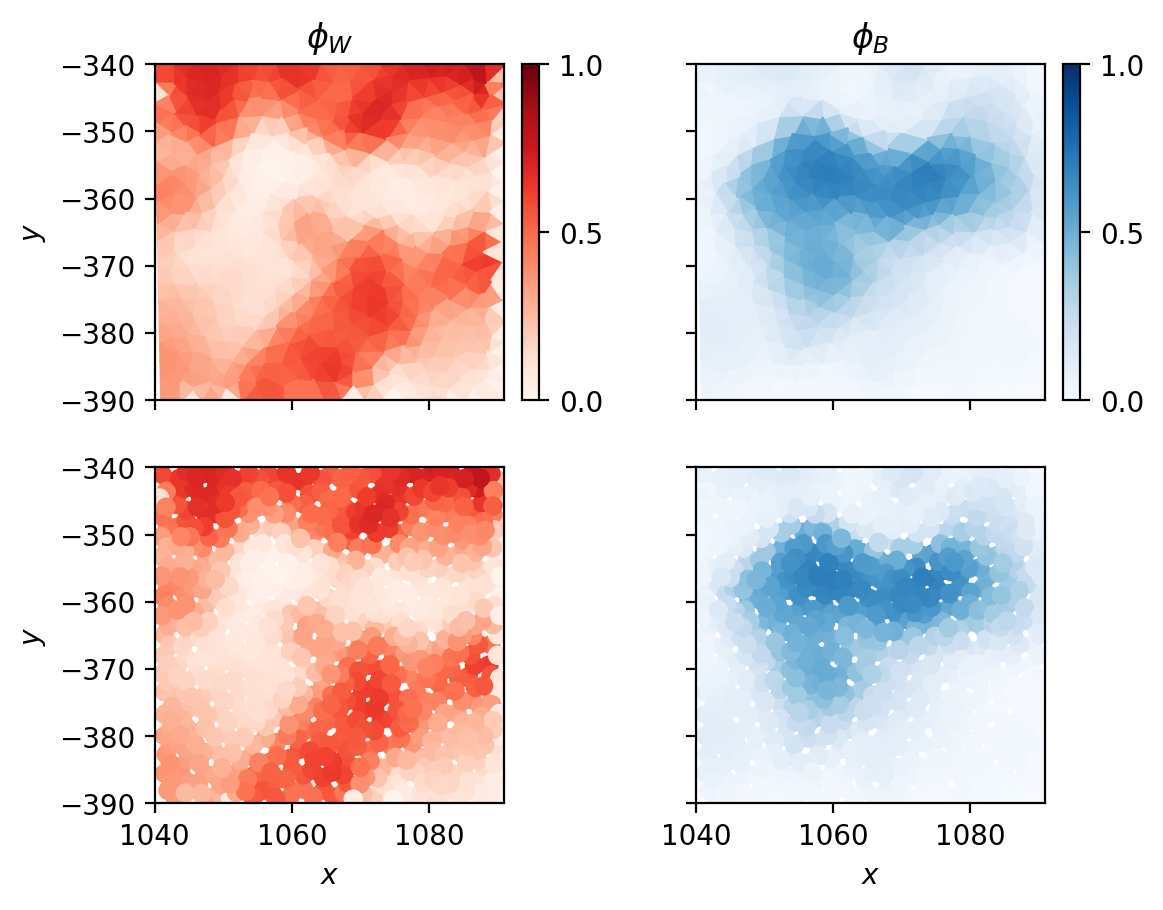

In [2]:
from fipy_dataset import FipyDataset
from fvm_utils import plot_mesh

dataset = FipyDataset(path="./data/Georgia_Fulton_small/fipy_output", remove_extra=False)
sample = dataset[5]

# Plot everything to make sure that things look correct
fig, ax = plt.subplots(2, 2, dpi=200, sharex=True, sharey=True)

# Plot original fipy objects
plot_mesh(sample['W0_mesh'], sample['W0_mesh'].mesh, ax[0, 0], cmap=plt.cm.Reds, vmin=0, vmax=1)
plot_mesh(sample['B0_mesh'], sample['B0_mesh'].mesh, ax[0, 1], cmap=plt.cm.Blues, vmin=0, vmax=1)

# Scatter plot the extracted objects
ax[1, 0].scatter(sample['X'], sample['Y'], c=sample['inputs'][0], cmap='Reds', vmin=0, vmax=1)
ax[1, 1].scatter(sample['X'], sample['Y'], c=sample['inputs'][1], cmap='Blues', vmin=0, vmax=1)

# Format subplots and axes
ax[0, 0].set_title('$\\phi_W$')
ax[0, 1].set_title('$\\phi_B$')

ax[0, 0].set_ylabel('$y$')
ax[1, 0].set(xlabel='$x$', ylabel='$y$')
ax[1, 1].set_xlabel('$x$')

for a in ax.flatten():
    a.set_aspect(np.ptp(a.get_ylim()) / np.ptp(a.get_xlim()))

# Spatial gradient testing: dolfin-adjoint

I want to compare the following

- Outputs and network gradients for spatial derivatives computed with dolfin-adjoint
- Outputs and network gradients for spatial derivatives computed with matrix pulled from dolfin
- Outputs and network gradients for spatial derivatives computed on a grid with mesh-grid interpolation

Fipy data has shape (776,) for mesh with vertices (2, 423) and cells (3, 776)
Dolfin data has shape (423,) for mesh with vertices (423, 2) and cells (776, 3)


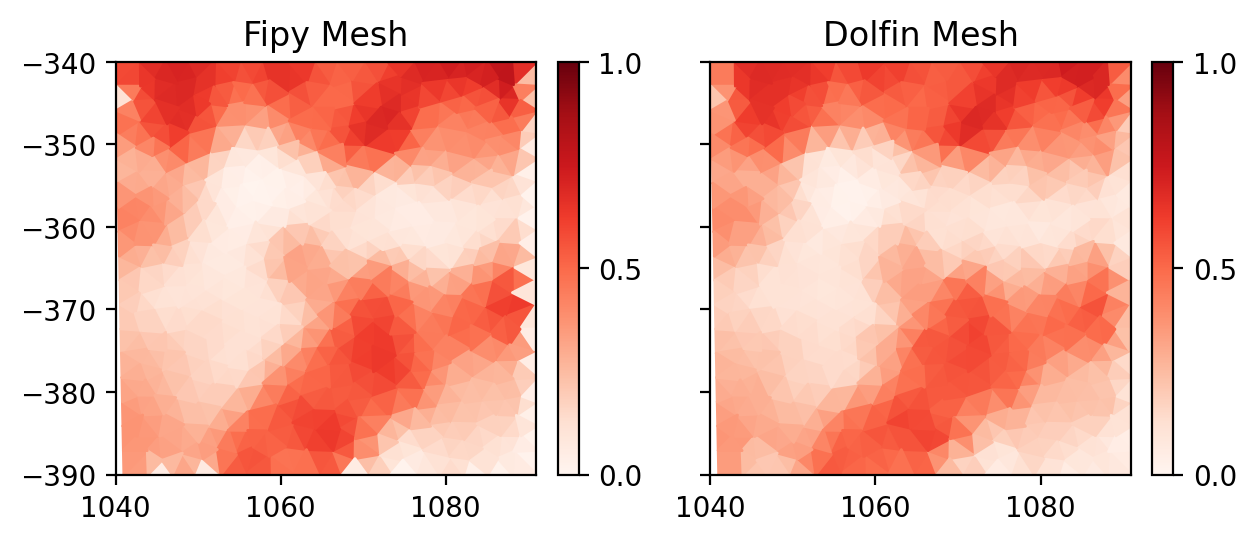

In [3]:
import dolfin_adjoint as d_ad
import dolfin as df
from scipy.interpolate import griddata

# Extract relevant information from fipy mesh
fipy_mesh = sample['W0_mesh'].mesh
vertices = fipy_mesh.vertexCoords.T
cells = fipy_mesh._orderedCellVertexIDs.T
centroids = fipy_mesh.cellCenters.value.T

# Build equivalent dolfin mesh
dolfin_mesh = d_ad.Mesh()
editor = df.MeshEditor()
editor.open(dolfin_mesh, 'triangle', 2, 2)

editor.init_vertices(vertices.shape[0])
for i, vertex in enumerate(vertices):
    editor.add_vertex(i, vertex)

editor.init_cells(cells.shape[0])
for i, cell in enumerate(cells):
    editor.add_cell(i, cell)

editor.close()

# Move fipy data (on cells) to dolfin data (on vertices)
fipy_data = sample['W0_mesh']
print(f'Fipy data has shape {fipy_data.shape} for mesh with vertices {fipy_mesh.vertexCoords.shape} and cells {fipy_mesh._orderedCellVertexIDs.shape}')
dolfin_data = griddata(centroids, fipy_data, vertices, method='nearest')
print(f'Dolfin data has shape {dolfin_data.shape} for mesh with vertices {dolfin_mesh.coordinates().shape} and cells {dolfin_mesh.cells().shape}')

# Plot data to see whether things look the same
fig, ax = plt.subplots(1, 2, dpi=200, sharex=True, sharey=True)
plot_mesh(fipy_data, fipy_mesh, ax[0], cmap=plt.cm.Reds, vmin=0, vmax=1) # Fipy
plot_mesh(dolfin_data, dolfin_mesh, ax[1], cmap=plt.cm.Reds, vmin=0, vmax=1) # Dolfin
ax[0].set_title('Fipy Mesh')
ax[1].set_title('Dolfin Mesh')
plt.tight_layout()

Solve the heat equation from some simple initial condition
\begin{align}
    \partial_t u &= \nabla^2 u \\
    u(0) &= x^2 + y^2
\end{align}

We can discretize this problem using forward differences
\begin{align}
    u_{n+1} &= u_{n} + \Delta t \, \nabla^2 u_{n}
\end{align}

Then this can be turned into a variational problem using an inner product with a test function as $\langle \cdot, v \rangle_{\Omega} = \int_{\Omega} \cdot \, v \, dx$
\begin{align}
    \langle u_{n+1}, v \rangle_{\Omega} &= \langle u_{n}, v \rangle_{\Omega} - \Delta t \langle \nabla u_{n}, \nabla v \rangle_{\Omega}
\end{align}

We'll start by comparing the forward problem

(423, 423) (423,)
Method 1 took 0.000269 s
------------------------
Exact-Dolfin MSE: 2.04e-05
Exact-Matrix MSE: 1.37e-05
Dolfin-Matrix MSE: 1.96e-05


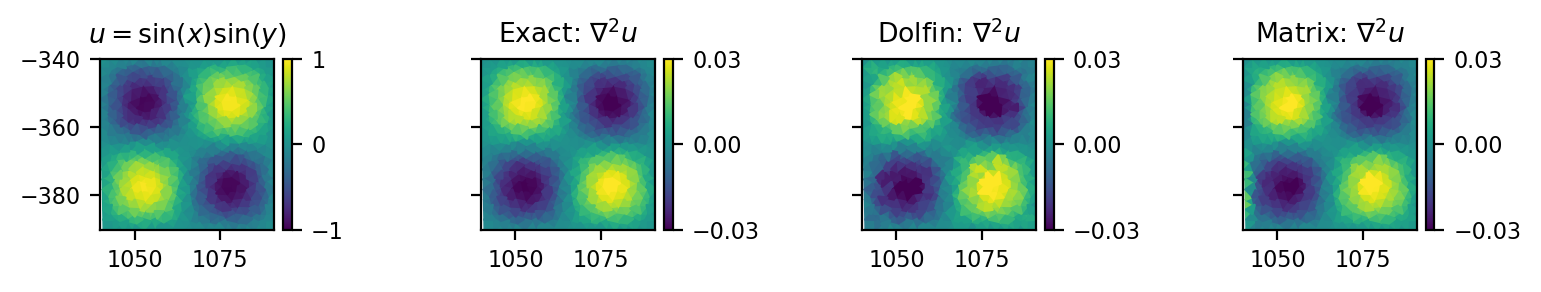

In [10]:
import ufl
import dolfin as df
import dolfin_adjoint as d_ad
import pyadjoint as pyad

from scipy import sparse
from time import time

plt.rcParams['font.size'] = 8

import logging

logging.getLogger('FFC').setLevel(logging.ERROR)
df.set_log_level(40)

xmin, ymin = np.min(dolfin_mesh.coordinates(), axis=0)
xptp, yptp = np.ptp(dolfin_mesh.coordinates(), axis=0) / (2 * np.pi)

element = ufl.FiniteElement('CG', dolfin_mesh.ufl_cell(), 1)
function_space = df.FunctionSpace(dolfin_mesh, element)

# Create the initial condition
u_0 = d_ad.Function(function_space)
u_0.interpolate(d_ad.Expression("sin((x[0]-xmin) / xptp) * sin((x[1]-ymin) / yptp)", 
                xptp=xptp, xmin=xmin, yptp=yptp, ymin=ymin, degree=2))

# Create the boundary condition
u_expr =  d_ad.Expression(
    "-(1/pow(xptp, 2) + 1/pow(yptp, 2)) * sin((x[0]-xmin) / xptp) * sin((x[1]-ymin) / yptp)",
    xptp=xptp, xmin=xmin, yptp=yptp, ymin=ymin, degree=2
)
bc = d_ad.DirichletBC(function_space, u_expr, "on_boundary")

# Method 0: Compute the exact solution
u_exact = d_ad.Function(function_space)
u_exact.interpolate(u_expr)
exact = u_exact.compute_vertex_values()

# Method 1: Create and solve the forward problem
u = df.TrialFunction(function_space)
v = df.TestFunction(function_space)

a = u * v * ufl.dx
L = -ufl.inner(ufl.grad(u_0), ufl.grad(v)) * ufl.dx

u_t = d_ad.Function(function_space)
d_ad.solve(a == L, u_t, bc)
dolfin_solution = u_t.compute_vertex_values()

# Method 2: Extract the solution matrix and use scipy sparse
d2v = df.dof_to_vertex_map(function_space)
v2d = df.vertex_to_dof_map(function_space)

# Needed to account for some internal scaling
diag = d_ad.assemble(v * ufl.dx)
diag = np.power(diag[:], -1)

a = -ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
A = d_ad.assemble(a)
bc.apply(A)
A = np.array(A.array())
A = sparse.csr_matrix(A)

print(A.shape, diag.shape)

# Method 2.1: Reorder solution vector: ~0.0001 s
t = time()
matrix_solution = A @ u_0.vector()[:] * diag
matrix_solution = matrix_solution[v2d]
print(f'Method 1 took {time()-t:.3g} s')

# Method 2.2: Reorder matrix: ~0.001 s
#t = time()
#A = A[:, v2d]
#A = A[v2d, :]
#diag = diag[v2d]
#matrix_solution = A @ u_0.compute_vertex_values() * diag
#print(f'Method 2 took {time()-t:.3g} s')

# Plot everything and compare
fig, ax = plt.subplots(1, 4, figsize=(8, 1.5), dpi=200, sharex=True, sharey=True)
ax = ax.flatten()
vmax = np.round(1/xptp**2 + 1/yptp**2, decimals=2)
vmin = -vmax

# RHS
plot_mesh(u_0.compute_vertex_values(), dolfin_mesh, ax[0], vmin=-1, vmax=1)
ax[0].set_title(r'$u = \sin(x) \sin(y)$')

# Exact solution
plot_mesh(exact, dolfin_mesh, ax[1], vmin=vmin, vmax=vmax)
ax[1].set_title(r'Exact: $\nabla^2 u$')

# Dolfin solution
plot_mesh(dolfin_solution, dolfin_mesh, ax[2], vmin=vmin, vmax=vmax)
ax[2].set_title(r'Dolfin: $\nabla^2 u$')

plot_mesh(matrix_solution, dolfin_mesh, ax[3], vmin=vmin, vmax=vmax)
ax[3].set_title(r'Matrix: $\nabla^2 u$')

print('------------------------')
print(f'Exact-Dolfin MSE: {np.mean(np.power(exact - dolfin_solution, 2)):.3g}')
print(f'Exact-Matrix MSE: {np.mean(np.power(exact - matrix_solution, 2)):.3g}')
print(f'Dolfin-Matrix MSE: {np.mean(np.power(dolfin_solution - matrix_solution, 2)):.3g}')

plt.tight_layout()

[Text(0.5, 0, 'Dolfin'), Text(0, 0.5, 'Matrix')]

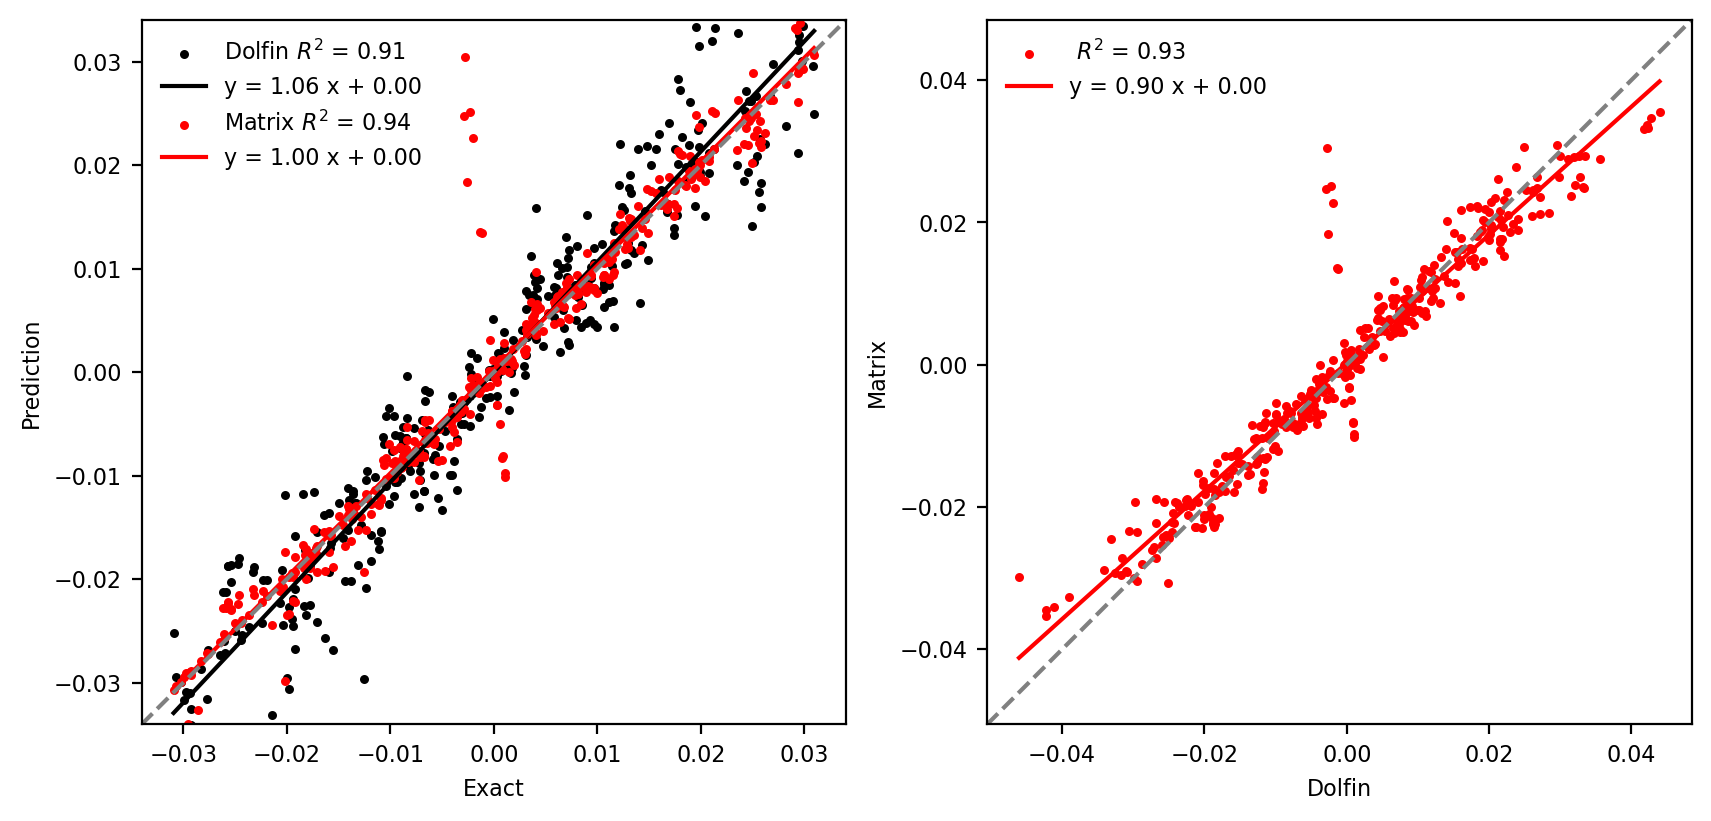

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

def plot_with_regression(ax, x, y, color='black', label=''):
    score = r2_score(x, y)
    label = ' '.join([label, f'$R^2$ = {score:.2f}'])
    ax.scatter(x, y, color=color, label=label, s=5)

    model = LinearRegression().fit(x[:,None], y[:,None])
    score = model.score(x[:, None], y[:, None])
    eqn = f'y = {model.coef_[0,0]:.2f} x + {np.squeeze(model.intercept_):.2f}'

    xr = np.array([np.min(x), np.max(x)])[:, None]
    yr = model.predict(xr)
    ax.plot(xr, yr, color=color, label=eqn)

plot_with_regression(ax[0], exact, dolfin_solution, label='Dolfin', color='black')
plot_with_regression(ax[0], exact, matrix_solution, label='Matrix', color='red')
plot_with_regression(ax[1], dolfin_solution, matrix_solution, color='red')

for a in ax:
    a.legend(framealpha=0)
    xlim, ylim = a.get_xlim(), a.get_ylim()
    a.plot(xlim, xlim, color='grey', linestyle='--')
    a.set(xlim=xlim, ylim=xlim, aspect='equal')

ax[0].set(xlabel='Exact', ylabel='Prediction')
ax[1].set(xlabel='Dolfin', ylabel='Matrix')


And now compare the backward problem implemented through dolfin adjoint

In [427]:
import ufl
import dolfin as df
import dolfin_adjoint as d_ad
import pyadjoint as pyad

from scipy import sparse
from time import time

plt.rcParams['font.size'] = 8
plt.rcParams['legend.framealpha'] = 0.

import logging

logging.getLogger('FFC').setLevel(logging.ERROR)
df.set_log_level(40)

xmin, ymin = np.min(dolfin_mesh.coordinates(), axis=0)
xptp, yptp = np.ptp(dolfin_mesh.coordinates(), axis=0) / (2 * np.pi)

element = ufl.FiniteElement('CG', dolfin_mesh.ufl_cell(), 1)
function_space = df.FunctionSpace(dolfin_mesh, element)

# Create the initial condition
u_0 = d_ad.Function(function_space)
u_0.interpolate(d_ad.Expression("sin((x[0]-xmin) / xptp) * sin((x[1]-ymin) / yptp)", 
                xptp=xptp, xmin=xmin, yptp=yptp, ymin=ymin, degree=2))

# Create the boundary condition
u_D = d_ad.Expression(
    "-(1/pow(xptp, 2) + 1/pow(yptp, 2)) * sin((x[0]-xmin) / xptp) * sin((x[1]-ymin) / yptp)",
    xptp=xptp, xmin=xmin, yptp=yptp, ymin=ymin, degree=2)
bc = d_ad.DirichletBC(function_space, u_D, "on_boundary")

# Method 0: Compute the exact solution
u_exact = d_ad.Function(function_space)
u_exact.interpolate(u_D)
exact = u_exact.compute_vertex_values()

# Method 1: Create and solve the forward problem
u = df.TrialFunction(function_space)
v = df.TestFunction(function_space)

a = u * v * ufl.dx
L = -ufl.inner(ufl.grad(u_0), ufl.grad(v)) * ufl.dx

u_t = d_ad.Function(function_space)
d_ad.solve(a == L, u_t, bc)
dolfin_solution = u_t.compute_vertex_values()
dolfin_solution = u_t.vector()[:]

loss = ufl.inner(u_t - u_exact, u_t - u_exact) * ufl.dx
J = d_ad.assemble(loss)
control = d_ad.Control(u_0)
Jhat = pyad.reduced_functional_numpy.ReducedFunctionalNumPy(J, control)
control = Jhat.obj_to_array([p.data() for p in Jhat.controls])

dolfin_loss = Jhat(control)
dolfin_grad = Jhat.derivative(control, forget=True, project=False)

print(f'dolfin-adjoint produces a loss of {dolfin_loss:.3g} and grad of size {dolfin_grad.shape}')

# Method 2: Extract the solution matrix and use scipy sparse
diag = d_ad.assemble(v * ufl.dx)[:] # approximate scale of dx

a = -ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
A = d_ad.assemble(a)
bc.apply(A)
A = np.array(A.array()) / diag[:, None] # Account for scale of dx

A = torch.FloatTensor(A).to_sparse()
diag = torch.FloatTensor(diag)
u_0_torch = torch.FloatTensor(u_0.vector()[:])
u_0_torch = torch.nn.Parameter(u_0_torch, requires_grad=True)
matrix_solution = A @ u_0_torch

torch_target = torch.FloatTensor(u_exact.vector()[:])

#matrix_loss = 0.5 * ((matrix_solution - torch_target) * diag).pow(2).sum()
matrix_loss = (matrix_solution - torch_target / diag).pow(2).sum()
matrix_loss.backward()
matrix_grad = u_0_torch.grad.numpy()

print(f'matrix-solution produces a loss of {matrix_loss.item():.3g} and grad of size {matrix_grad.shape}')

# Methods 3: Use solution matrix but assembled loss problem
loss = ufl.inner(u_t - u_exact, u_t - u_exact) * ufl.dx
J = d_ad.assemble(loss)
control = d_ad.Control(u_t)
Jhat = pyad.reduced_functional_numpy.ReducedFunctionalNumPy(J, control)
control = Jhat.obj_to_array([p.data() for p in Jhat.controls])

u_0_torch = torch.FloatTensor(u_0.vector()[:])
u_0_torch = torch.nn.Parameter(u_0_torch, requires_grad=True)
assembled_solution = A @ u_0_torch
u_t.vector()[:] = assembled_solution.detach().numpy()
control[:] = assembled_solution.detach().numpy()

assembled_loss = Jhat(control)
assembled_grad = Jhat.derivative(control, forget=True, project=False)
assembled_solution.backward(gradient=torch.tensor(assembled_grad))
assembled_grad = u_0_torch.grad.numpy()

print(f'matrix-assembled produces a loss of {assembled_loss:.3g} and grad of size {assembled_grad.shape}')

dolfin-adjoint produces a loss of 0.0173 and grad of size (423,)
matrix-solution produces a loss of 0.0702 and grad of size (423,)
matrix-assembled produces a loss of 0.0127 and grad of size (423,)


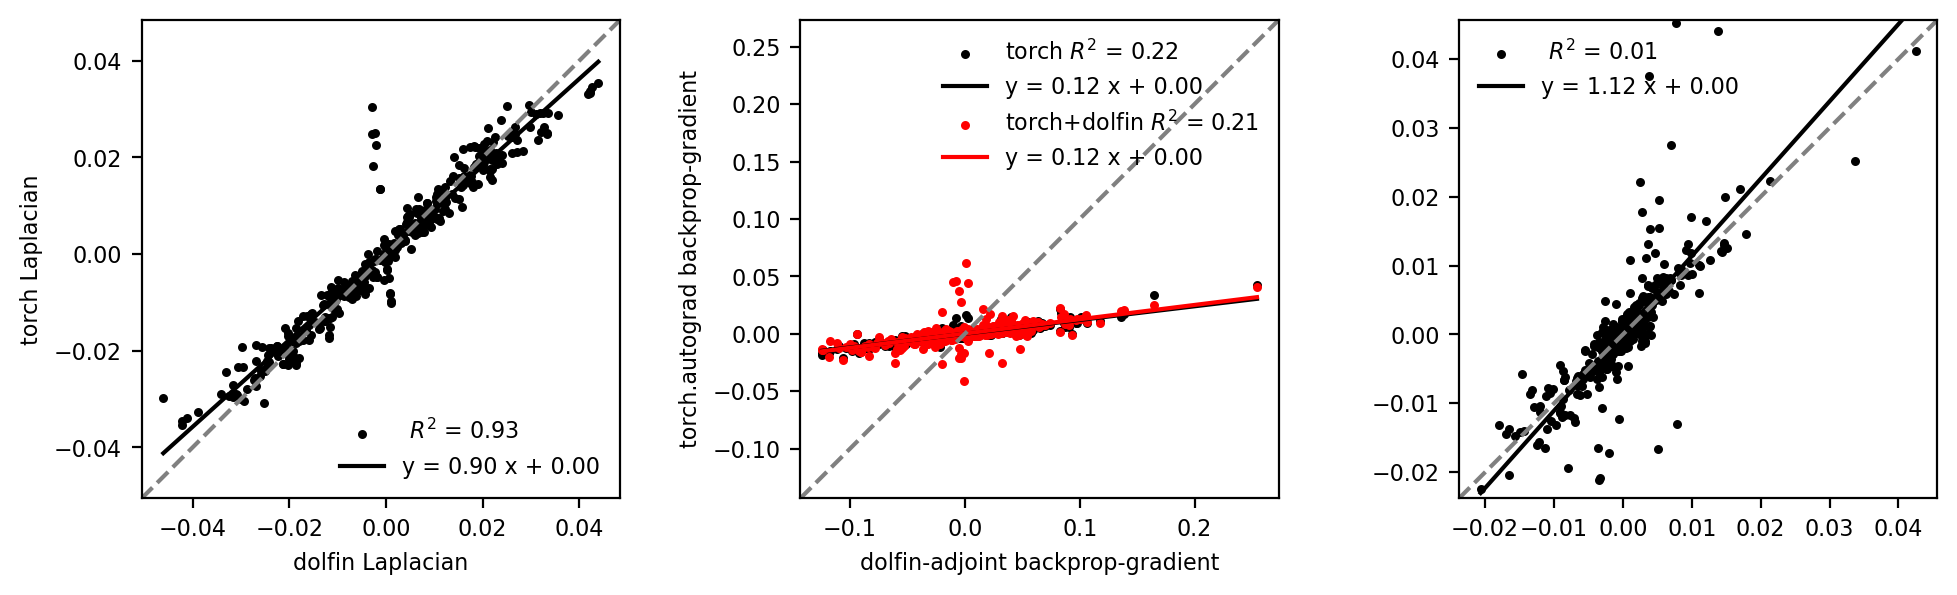

In [428]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), dpi=200)
plot_with_regression(ax[0], dolfin_solution, matrix_solution.detach().numpy())
plot_with_regression(ax[1], dolfin_grad, matrix_grad, label='torch')
plot_with_regression(ax[1], dolfin_grad, assembled_grad, color='red', label='torch+dolfin')
plot_with_regression(ax[2], matrix_grad, assembled_grad)

ax[0].set(xlabel='dolfin Laplacian', ylabel='torch Laplacian')
ax[1].set(xlabel='dolfin-adjoint backprop-gradient', ylabel='torch.autograd backprop-gradient')

for a in ax:
    a.legend()
    xlim, ylim = a.get_xlim(), a.get_ylim()
    a.plot(xlim, xlim, color='grey', linestyle='--')
    a.set(xlim=xlim, ylim=xlim, aspect='equal')

plt.tight_layout()

dolfin-adjoint produces a loss of 0.0173 and grad of size (423,)
matrix-solution produces a loss of 0.0482 and grad of size torch.Size([423])


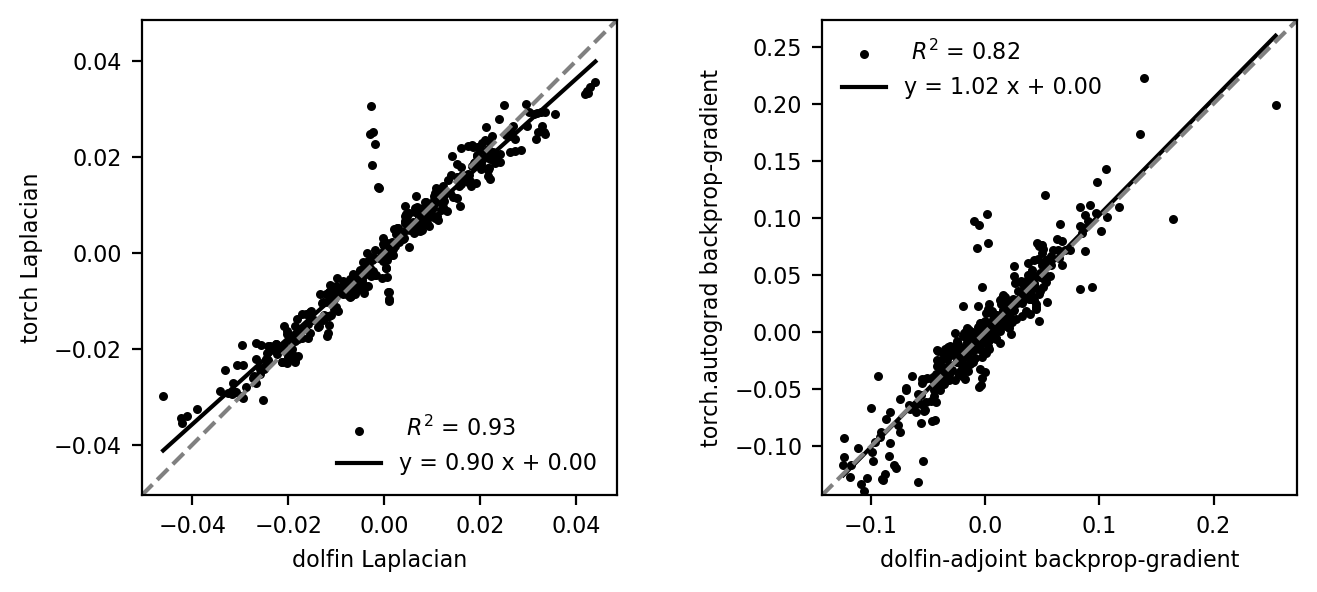

In [424]:
import ufl
import dolfin as df
import dolfin_adjoint as d_ad
import pyadjoint as pyad

from scipy import sparse
from time import time

plt.rcParams['font.size'] = 8
plt.rcParams['legend.framealpha'] = 0.

import logging

logging.getLogger('FFC').setLevel(logging.ERROR)
df.set_log_level(40)

xmin, ymin = np.min(dolfin_mesh.coordinates(), axis=0)
xptp, yptp = np.ptp(dolfin_mesh.coordinates(), axis=0) / (2 * np.pi)

element = ufl.FiniteElement('CG', dolfin_mesh.ufl_cell(), 1)
function_space = df.FunctionSpace(dolfin_mesh, element)

# Create the initial condition
u_0 = d_ad.Function(function_space)
u_0.interpolate(d_ad.Expression("sin((x[0]-xmin) / xptp) * sin((x[1]-ymin) / yptp)", 
                xptp=xptp, xmin=xmin, yptp=yptp, ymin=ymin, degree=2))

# Create the boundary condition
u_D = d_ad.Expression(
    "-(1/pow(xptp, 2) + 1/pow(yptp, 2)) * sin((x[0]-xmin) / xptp) * sin((x[1]-ymin) / yptp)",
    xptp=xptp, xmin=xmin, yptp=yptp, ymin=ymin, degree=2)
bc = d_ad.DirichletBC(function_space, u_D, "on_boundary")

# Method 0: Compute the exact solution
u_exact = d_ad.Function(function_space)
u_exact.interpolate(u_D)
exact = u_exact.compute_vertex_values()

# Method 1: Create and solve the forward problem
u = df.TrialFunction(function_space)
v = df.TestFunction(function_space)

a = u * v * ufl.dx
L = -ufl.inner(ufl.grad(u_0), ufl.grad(v)) * ufl.dx

u_t = d_ad.Function(function_space)
d_ad.solve(a == L, u_t, bc)
dolfin_solution = u_t.compute_vertex_values()
dolfin_solution = u_t.vector()[:]

loss = ufl.inner(u_t - u_exact, u_t - u_exact) * ufl.dx
J = d_ad.assemble(loss)
control = d_ad.Control(u_0)
Jhat = pyad.reduced_functional_numpy.ReducedFunctionalNumPy(J, control)
control = Jhat.obj_to_array([p.data() for p in Jhat.controls])

dolfin_loss = Jhat(control)
dolfin_grad = Jhat.derivative(control, forget=True, project=False)

print(f'dolfin-adjoint produces a loss of {dolfin_loss:.3g} and grad of size {dolfin_grad.shape}')

# Method 2: Extract the solution matrix and use scipy sparse
diag = d_ad.assemble(v * ufl.dx)[:]

a = -ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
A = d_ad.assemble(a)
bc.apply(A)
A = np.array(A.array()) / diag[:, None]

A = torch.FloatTensor(A).to_sparse()
diag = torch.FloatTensor(diag)
u_0_torch = torch.FloatTensor(u_0.vector()[:])
u_0_torch = torch.nn.Parameter(u_0_torch, requires_grad=True)
matrix_solution = A @ u_0_torch

torch_target = torch.FloatTensor(u_exact.vector()[:])

matrix_loss = 0.5 * ((matrix_solution - torch_target) * diag).pow(2).sum()
matrix_loss.backward()
matrix_grad = u_0_torch.grad

print(f'matrix-solution produces a loss of {matrix_loss.item():.3g} and grad of size {matrix_grad.shape}')

fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=200)
plot_with_regression(ax[0], dolfin_solution, matrix_solution.detach().numpy())
plot_with_regression(ax[1], dolfin_grad, matrix_grad.numpy())

ax[0].set(xlabel='dolfin Laplacian', ylabel='torch Laplacian')
ax[1].set(xlabel='dolfin-adjoint backprop-gradient', ylabel='torch.autograd backprop-gradient')

for a in ax:
    a.legend()
    xlim, ylim = a.get_xlim(), a.get_ylim()
    a.plot(xlim, xlim, color='grey', linestyle='--')
    a.set(xlim=xlim, ylim=xlim, aspect='equal')

plt.tight_layout()

# Spatial gradient testing: hacked-together fipy spatial gradients

# Network gradient testing: $\frac{\delta f_{NN}[\phi]}{\delta \phi}$

In [5]:
from time import time
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Testing gradient computation functions
inputs = sample['inputs'][None].to(device)
ϕW = inputs[:, 0].clone().detach().requires_grad_(True)
ϕB = inputs[:, 1].clone().detach().requires_grad_(True)
inp = torch.stack([ϕW, ϕB], dim=1)

coefs = torch.empty([1, 1, 4, inputs.shape[-1]], device=device)
coefs[:, 0, 0] = 2. * inp[:, 0] + 0.5 * inp[:, 1] # Linear func
coefs[:, 0, 1] = 0.5 * inp[:, 0].pow(2) + 0.3 * inp[:, 1].pow(2) # Quadratic func
coefs[:, 0, 2] = 0.2 * inp[:, 0].pow(3) + 0.1 * inp[:, 1].pow(3) # Cubic func
coefs[:, 0, 3] = 0.7 * inp[:, 0].pow(2) * inp[:, 1].pow(7) # Mixed func

# Compute second derivative of coefs w.r.t. phi
def grad_func(output, input, **kwargs):
    t = time()
    grad_outputs = torch.ones_like(input)
    kwargs = dict(grad_outputs=grad_outputs, **kwargs)

    grad = []
    for cc in range(output.shape[1]):
        gcc = []
        for ff in range(output.shape[2]):
            gcc.append(torch.autograd.grad(output[:, cc, ff], input, **kwargs)[0])
        grad.append(torch.stack(gcc, dim=1))
    
    grad = torch.stack(grad, dim=1)
    print(f'Done, {time()-t:.2g} s', grad.shape, flush=True)
    return grad

print('-------------------------------')
print('Computing 1st order derivatives')
print('-------------------------------')

c_W = grad_func(coefs, ϕW, create_graph=True)
c_B = grad_func(coefs, ϕB, create_graph=True)
print()

# Check that 1st order derivatives are correct
print('-------------------------------')
print('1st order Verification')
print('-------------------------------')
print('Linear func:\t', 
      torch.allclose(c_W[:,:,0], torch.tensor(2.)), 
      torch.allclose(c_B[:,:,0], torch.tensor(0.5))
)
print('Quadratic func:\t', 
      torch.allclose(c_W[:,:,1], 0.5 * 2 * ϕW),
      torch.allclose(c_B[:,:,1], 0.3 * 2 * ϕB),
)
print('Cubic func:\t', 
      torch.allclose(c_W[:,:,2], 0.2 * 3 * ϕW.pow(2)),
      torch.allclose(c_B[:,:,2], 0.1 * 3 * ϕB.pow(2)),
)
print('Mixed func:\t', 
      torch.allclose(c_W[:,:,3], 0.7 * 2 * ϕW.pow(1) * ϕB.pow(7)),
      torch.allclose(c_B[:,:,3], 0.7 * 7 * ϕW.pow(2) * ϕB.pow(6)),
)
print()

print('-------------------------------')
print('Computing 2nd order derivatives')
print('-------------------------------')
c_WW = grad_func(c_W, ϕW, retain_graph=True)
c_WB = grad_func(c_W, ϕB, retain_graph=True)
c_BW = grad_func(c_B, ϕW, retain_graph=True)
c_BB = grad_func(c_B, ϕB, retain_graph=True)
print()

# Check that 1st order derivatives are correct
print('-------------------------------')
print('2nd order Verification')
print('-------------------------------')
print('Linear func:\t', 
      torch.allclose(c_WW[:,:,0], torch.tensor(0.)), 
      torch.allclose(c_WB[:,:,0], torch.tensor(0.)),
      torch.allclose(c_BW[:,:,0], torch.tensor(0.)),
      torch.allclose(c_BB[:,:,0], torch.tensor(0.)),
)
print('Quadratic func:\t', 
      torch.allclose(c_WW[:,:,1], torch.tensor(0.5 * 2)),
      torch.allclose(c_WB[:,:,1], torch.tensor(0.)),
      torch.allclose(c_BW[:,:,1], torch.tensor(0.)),
      torch.allclose(c_BB[:,:,1], torch.tensor(0.3 * 2)),
)
print('Cubic func:\t', 
      torch.allclose(c_WW[:,:,2], 0.2 * 6 * ϕW),
      torch.allclose(c_WB[:,:,2], torch.tensor(0.)),
      torch.allclose(c_BW[:,:,2], torch.tensor(0.)),
      torch.allclose(c_BB[:,:,2], 0.1 * 6 * ϕB),
)
print('Mixed func:\t', 
      torch.allclose(c_WW[:,:,3], 0.7 * 2  * ϕW.pow(0) * ϕB.pow(7)),
      torch.allclose(c_WB[:,:,3], 0.7 * 14 * ϕW.pow(1) * ϕB.pow(6)),
      torch.allclose(c_BW[:,:,3], 0.7 * 14 * ϕW.pow(1) * ϕB.pow(6)),
      torch.allclose(c_BB[:,:,3], 0.7 * 42 * ϕW.pow(2) * ϕB.pow(5)),

)
print()

-------------------------------
Computing 1st order derivatives
-------------------------------
Done, 0.25 s torch.Size([1, 1, 4, 607])
Done, 0.01 s torch.Size([1, 1, 4, 607])

-------------------------------
1st order Verification
-------------------------------
Linear func:	 True True
Quadratic func:	 True True
Cubic func:	 True True
Mixed func:	 True True

-------------------------------
Computing 2nd order derivatives
-------------------------------
Done, 0.025 s torch.Size([1, 1, 4, 607])
Done, 0.017 s torch.Size([1, 1, 4, 607])
Done, 0.017 s torch.Size([1, 1, 4, 607])
Done, 0.019 s torch.Size([1, 1, 4, 607])

-------------------------------
2nd order Verification
-------------------------------
Linear func:	 True True True True
Quadratic func:	 True True True True
Cubic func:	 True True True True
Mixed func:	 True True True True

